## 1. IMPORT LIBRARIES

In [4]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# Import Preprocess and Model Libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
#from keras.layers.experimental import preprocessing
#from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
K.set_image_data_format('channels_last')

In [6]:
# Import Other Libraries
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

## 2. LOAD, DISCOVER AND PREPROCESS THE DATA

### 2.1. Load the Data

In [7]:
# Load the Fashion MNIST dataset
(train_dataset, test_dataset), dataset_info = tfds.load('fashion_mnist'
                                        , split=['train', 'test']
                                        , shuffle_files=True
                                        , as_supervised=True
                                        , with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8T271L/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8T271L/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
# Define class names
class_names = dataset_info.features['label'].names
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### 2.2. Number of Examples

In [9]:
train_num = dataset_info.splits['train'].num_examples
print("Number of examples in train datasets is " + str(train_num))

test_num = dataset_info.splits['test'].num_examples
print("Number of examples test datasets is " + str(test_num))

Number of examples in train datasets is 60000
Number of examples test datasets is 10000


### 2.3. Normalization and Caching

In [10]:
def normalize_images(images, labels):
  return tf.cast(images, tf.float32)/255.0, labels

# Normalize the train and test datasets
normalized_train = train_dataset.map(normalize_images)
normalized_test= test_dataset.map(normalize_images)

# The code caches the training and test datasets in memory
# , allowing for faster access during subsequent operations.
normalized_train =  normalized_train.cache()
normalized_test  =  normalized_test.cache()

### 2.4. Display Examples

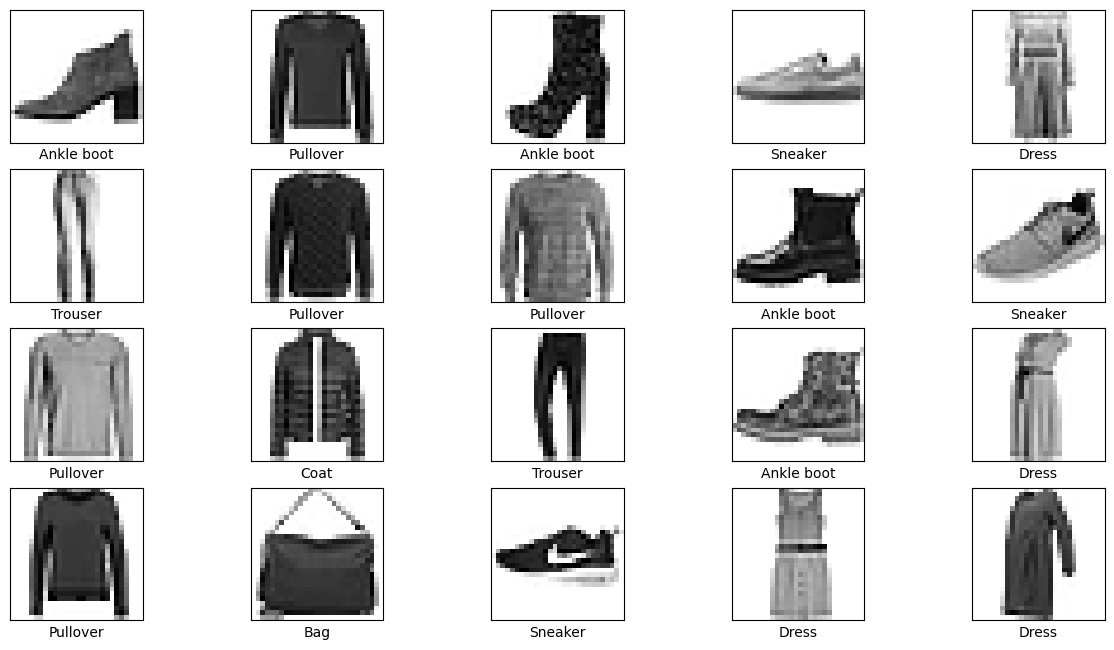

In [11]:
'''
Display 20 random images from test dataset
'''

# Function to display a grid of images
def display_images(images, labels, class_names, ncols=5):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(len(images) // ncols + 1, ncols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(class_names[label])
    plt.show()

# Select 20 random images from the test set
random_indices = np.random.choice(len(normalized_test), size=20, replace=False)
random_images = []
random_labels = []
for i in random_indices:
    for image, label in normalized_test.skip(i).take(1):
        random_images.append(image.numpy())
        random_labels.append(label.numpy())

# Display the random images
display_images(random_images, random_labels, class_names)

### 2.5. Bias Control

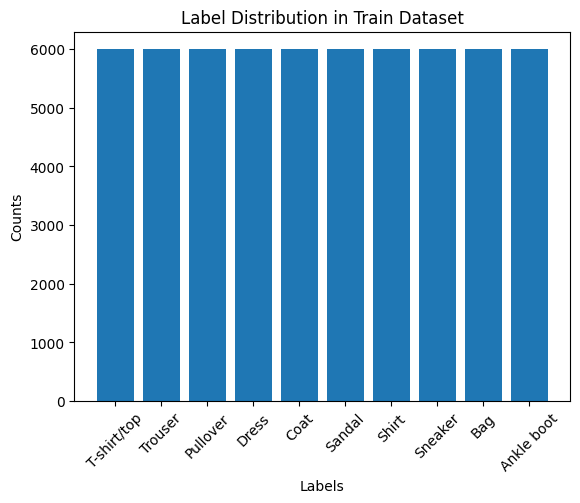

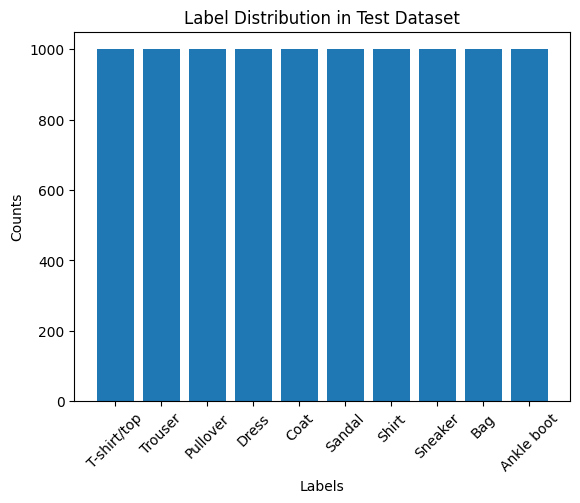

In [12]:
def label_graph_creator(dataset, class_names, title_=''):
  # Initialize an empty dictionary to store label counts
  label_counts = {label: 0 for label in class_names}

  # Iterate through the dataset to count the occurrences of each label
  for _, label in dataset:
    label_name = class_names[label.numpy()]
    label_counts[label_name] += 1

  # Plot the bar graph
  plt.bar(label_counts.keys(), label_counts.values())
  plt.xlabel('Labels')
  plt.ylabel('Counts')
  plt.title(title_)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
  plt.show()

label_graph_creator(normalized_train, class_names, title_='Label Distribution in Train Dataset')
label_graph_creator(normalized_test, class_names, title_='Label Distribution in Test Dataset')


As presented above charts, both training and test datasets are equally distributed on the classes. Hence, we do not have to worry about any biases in the data.


### 2.7. Preparing Features and Labels

In [13]:
# Extract images and labels
X_train, y_train = [], []
for image, label in normalized_train:
    X_train.append(image.numpy())
    y_train.append(label.numpy())

X_test, y_test = [], []
for image, label in normalized_test:
    X_test.append(image.numpy())
    y_test.append(label.numpy())

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
# Check the shape of datasets
print(" Shape of X_train " , str(X_train.shape))
print(" Shape of y_train " , str(y_train.shape))
print(" Shape of X_test " , str(X_test.shape))
print(" Shape of y_test " , str(y_test.shape))

 Shape of X_train  (60000, 28, 28, 1)
 Shape of y_train  (60000, 10)
 Shape of X_test  (10000, 28, 28, 1)
 Shape of y_test  (10000, 10)


## 3. MODEL DEVELOPMENT AND EVALUATION

### 3.1. Base Model

In this section, we will be developing, training and evaluating a model with a two hidden layer fully connected neural network by using Stochastic Gradient Descent (SGD) optimizer, the Sigmoid Activation function, and the cross-entropy error function.

In [16]:
# Create the model
model_1 = Sequential()

In [17]:
# Build the neural network model
model_1.add(Flatten(input_shape=(28, 28, 1)))
model_1.add(Dense(128, activation='sigmoid'))
model_1.add(Dense(64, activation='sigmoid'))
model_1.add(Dense(10, activation='softmax'))

In [18]:
# Compile the model
model_1.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
batch_size_1 = 1000
epoch_1 = 10

# Train the model
history_1 = model_1.fit(X_train, y_train, epochs=epoch_1, batch_size=batch_size_1, validation_data=(X_test, y_test))

Epoch 1/10
60/60 [==============================] - 2s 18ms/step - loss: 2.3273 - accuracy: 0.0957 - val_loss: 2.3002 - val_accuracy: 0.0792
Epoch 2/10
60/60 [==============================] - 1s 14ms/step - loss: 2.2905 - accuracy: 0.1263 - val_loss: 2.2830 - val_accuracy: 0.1833
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 2.2767 - accuracy: 0.2296 - val_loss: 2.2708 - val_accuracy: 0.2505
Epoch 4/10
60/60 [==============================] - 1s 14ms/step - loss: 2.2645 - accuracy: 0.2916 - val_loss: 2.2588 - val_accuracy: 0.3433
Epoch 5/10
60/60 [==============================] - 1s 14ms/step - loss: 2.2523 - accuracy: 0.3783 - val_loss: 2.2464 - val_accuracy: 0.3696
Epoch 6/10
60/60 [==============================] - 1s 22ms/step - loss: 2.2397 - accuracy: 0.3958 - val_loss: 2.2337 - val_accuracy: 0.4072
Epoch 7/10
60/60 [==============================] - 1s 23ms/step - loss: 2.2266 - accuracy: 0.4123 - val_loss: 2.2203 - val_accuracy: 0.4517
Epoch 8/10
60

In [20]:
# Evaluate the model
test_loss_1, test_acc_1 = model_1.evaluate(X_test, y_test)
print("Test accuracy:", "{:.1%}".format(test_acc_1))

313/313 [==============================] - 1s 2ms/step - loss: 2.1758 - accuracy: 0.4804
Test accuracy: 48.0%


The accuracy of the model on the test data is 48.7%, which is not very satisfying. Hence, we will try to improve the accuracy in the upcoming sections.

### 3.2. The Second Model with ReLU

In this section, we will be changing the Sigmoid activation function with relu. And again train the model with the new activation function and evaluate the results, comparing with the base model.

In [21]:
# Create the model
model_2 = Sequential()

In [22]:
# Build the neural network model
model_2.add(Flatten(input_shape=(28, 28, 1)))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(10, activation='softmax'))

In [23]:
# Compile the model
model_2.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
batch_size_2 = 1000
epoch_2 = 10

# Train the model
history_2 = model_2.fit(X_train, y_train, epochs=epoch_2, batch_size=batch_size_2, validation_data=(X_test, y_test))

Epoch 1/10
60/60 [==============================] - 1s 17ms/step - loss: 2.0044 - accuracy: 0.3413 - val_loss: 1.7091 - val_accuracy: 0.5558
Epoch 2/10
60/60 [==============================] - 1s 14ms/step - loss: 1.4848 - accuracy: 0.6198 - val_loss: 1.2988 - val_accuracy: 0.6415
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 1.1629 - accuracy: 0.6669 - val_loss: 1.0681 - val_accuracy: 0.6716
Epoch 4/10
60/60 [==============================] - 1s 13ms/step - loss: 0.9884 - accuracy: 0.7002 - val_loss: 0.9441 - val_accuracy: 0.6990
Epoch 5/10
60/60 [==============================] - 1s 13ms/step - loss: 0.8879 - accuracy: 0.7235 - val_loss: 0.8655 - val_accuracy: 0.7199
Epoch 6/10
60/60 [==============================] - 1s 14ms/step - loss: 0.8217 - accuracy: 0.7397 - val_loss: 0.8118 - val_accuracy: 0.7323
Epoch 7/10
60/60 [==============================] - 1s 19ms/step - loss: 0.7742 - accuracy: 0.7515 - val_loss: 0.7720 - val_accuracy: 0.7434
Epoch 8/10
60

In [25]:
# Evaluate the model
test_loss_2, test_acc_2 = model_2.evaluate(X_test, y_test)
print("Test accuracy:", "{:.1%}".format(test_acc_2))

313/313 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.7662
Test accuracy: 76.6%


As observed above, the accuracy of evaluation on the test data has significantly increased from 48.7% to 75.2%. There are several reasons of this improvement as explained below.

**Avoiding vanishing gradients:** Sigmoid activation functions can have a problem where the gradients become very small during learning in deep neural networks. This can make learning difficult. ReLU doesn't have this problem as much because it only stops at 0.

**Sparse activation:** ReLU makes many neurons output zero. This can help the model learn better by reducing unnecessary information and making the model more diverse.

### 3.3. The Third Model with Dropout Regularization

In this section, we will be implementing a dropout regularization into the model. Then, we will train and evaluate the model.

In [26]:
# Create the model
model_3 = Sequential()

In [27]:
# Build the neural network model
model_3.add(Flatten(input_shape=(28, 28, 1)))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='softmax'))

In [28]:
# Compile the model
model_3.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
batch_size_3 = 1000
epoch_3 = 10

# Train the model
history_3 = model_3.fit(X_train, y_train, epochs=epoch_3, batch_size=batch_size_3, validation_data=(X_test, y_test))

Epoch 1/10
60/60 [==============================] - 2s 18ms/step - loss: 2.0488 - accuracy: 0.2937 - val_loss: 1.7224 - val_accuracy: 0.5638
Epoch 2/10
60/60 [==============================] - 1s 15ms/step - loss: 1.6268 - accuracy: 0.4898 - val_loss: 1.3549 - val_accuracy: 0.6272
Epoch 3/10
60/60 [==============================] - 1s 15ms/step - loss: 1.3690 - accuracy: 0.5544 - val_loss: 1.1410 - val_accuracy: 0.6463
Epoch 4/10
60/60 [==============================] - 1s 15ms/step - loss: 1.2121 - accuracy: 0.5888 - val_loss: 1.0172 - val_accuracy: 0.6614
Epoch 5/10
60/60 [==============================] - 1s 15ms/step - loss: 1.1120 - accuracy: 0.6125 - val_loss: 0.9390 - val_accuracy: 0.6766
Epoch 6/10
60/60 [==============================] - 1s 15ms/step - loss: 1.0475 - accuracy: 0.6291 - val_loss: 0.8874 - val_accuracy: 0.6892
Epoch 7/10
60/60 [==============================] - 1s 15ms/step - loss: 0.9946 - accuracy: 0.6461 - val_loss: 0.8482 - val_accuracy: 0.6998
Epoch 8/10
60

In [30]:
# Evaluate the model
test_loss_3, test_acc_3 = model_3.evaluate(X_test, y_test)
print("Test accuracy:", "{:.1%}".format(test_acc_3))

313/313 [==============================] - 1s 2ms/step - loss: 0.7726 - accuracy: 0.7237
Test accuracy: 72.4%


Even if we did not keep dropout ratio very high, the accuracy has decreased from 75.2% to 73.8%. Dropout introduces randomness into the training process, which means that the performance of the model may vary across different runs. It's possible that the decrease in accuracy is due to random fluctuations rather than a fundamental issue with dropout regularization. Additionally, dropout regularization can slow down the convergence of the training process because it introduces randomness into the network. If the model is not trained for enough epochs, the model may not have had sufficient time to learn meaningful patterns from the data.|As a result, we may overcome this issue by increasing the value of epoch hyperparameter.

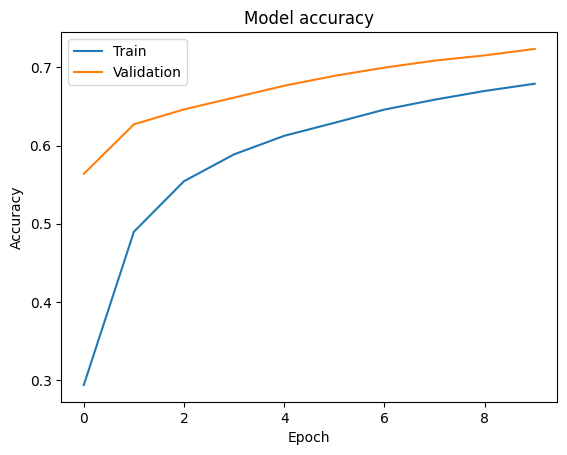

In [47]:
# Plot training & validation accuracy values
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 3.4. The Fourth Model with Dropout Regularization and Increased Epoch Value

In the previous section, we have introduced Dropout regularization into the model. However, it decreased the accuracy. The reason may be the insufficient training time. Hence, we will increase the value of epoch hyperparameter and train and evaluate the model.

In [31]:
# Create the model
model_4 = Sequential()

In [32]:
# Build the neural network model
model_4.add(Flatten(input_shape=(28, 28, 1)))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(10, activation='softmax'))

In [33]:
# Compile the model
model_4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
batch_size_4 = 1000
epoch_4 = 50

# Train the model
history_4 = model_4.fit(X_train, y_train, epochs=epoch_4, batch_size=batch_size_4, validation_data=(X_test, y_test))

Epoch 1/50
60/60 [==============================] - 2s 18ms/step - loss: 2.0685 - accuracy: 0.2906 - val_loss: 1.7110 - val_accuracy: 0.5433
Epoch 2/50
60/60 [==============================] - 1s 16ms/step - loss: 1.6154 - accuracy: 0.4876 - val_loss: 1.3423 - val_accuracy: 0.6456
Epoch 3/50
60/60 [==============================] - 1s 16ms/step - loss: 1.3682 - accuracy: 0.5529 - val_loss: 1.1417 - val_accuracy: 0.6675
Epoch 4/50
60/60 [==============================] - 1s 15ms/step - loss: 1.2242 - accuracy: 0.5899 - val_loss: 1.0244 - val_accuracy: 0.6799
Epoch 5/50
60/60 [==============================] - 1s 15ms/step - loss: 1.1230 - accuracy: 0.6161 - val_loss: 0.9475 - val_accuracy: 0.6907
Epoch 6/50
60/60 [==============================] - 1s 15ms/step - loss: 1.0561 - accuracy: 0.6354 - val_loss: 0.8931 - val_accuracy: 0.7025
Epoch 7/50
60/60 [==============================] - 1s 15ms/step - loss: 1.0055 - accuracy: 0.6510 - val_loss: 0.8521 - val_accuracy: 0.7081
Epoch 8/50
60

In [35]:
# Evaluate the model
test_loss_4, test_acc_4 = model_4.evaluate(X_test, y_test)
print("Test accuracy:", "{:.1%}".format(test_acc_4))

313/313 [==============================] - 1s 2ms/step - loss: 0.5161 - accuracy: 0.8172
Test accuracy: 81.7%


Indeed, as anticipated, increasing the number of epochs has notably enhanced the model's accuracy. This enhancement stems from the increased exposure to training data and the subsequent more frequent parameter updates. Consequently, this facilitates the model in discerning intricate patterns within the data, resulting in the convergence towards an improved solution. Consequently, this augmentation in epochs aids in leveraging the beneficial generalization capabilities inherent in dropout regularization.







### 3.5. The Fifth Model with GridSearch

In this section, we will apply grid search method to find the bets hyperparameters

In [36]:
# Define the neural network model function
def build_model(learning_rate=0.001, momentum=0.9, dropout_rate=0.2, epochs=50):

  # Initiate the same model that we built for previous sections
  model = Sequential()
  model.add(Flatten(input_shape=(28, 28, 1)))
  # First layer
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  # Second layer
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  # Final layer
  model.add(Dense(10, activation='softmax'))

  decay = learning_rate/epochs

  optimizer = SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [37]:
# Define hyperparameters
learning_rates = [0.001, 0.01, 0.1]
momentums = [0.9, 0.95, 0.99]
dropout_rates = [0.1, 0.2, 0.4]

**WARNING:** EXECUTING BELOW CELL MAY TAKE ABOUT **30 MINUTES**

In [38]:
epochs = 50
batch_size = 1000

best_accuracy = 0
best_params = {}
model_number = 1

results_data = []

# Perform grid search
for learning_rate in learning_rates:
    for momentum in momentums:
        for dropout_rate in dropout_rates:
            print(f"Training model with learning_rate={learning_rate}, momentum={momentum}, dropout_rate={dropout_rate}")
            model = build_model(learning_rate=learning_rate, momentum=momentum, dropout_rate=dropout_rate)
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test) , verbose=None)
            _, accuracy = model.evaluate(X_test, y_test)
            print(f"Test accuracy: {accuracy}")

            # Append the results to the list of dictionaries
            results_data.append({'model_number': model_number,
                                 'learning_rate': learning_rate,
                                 'momentum': momentum,
                                 'dropout_rate': dropout_rate,
                                 'accuracy': accuracy})
            model_number += 1

# Create DataFrame from the list of model evaluation dictionaries
results = pd.DataFrame(results_data)

Training model with learning_rate=0.001, momentum=0.9, dropout_rate=0.1
313/313 [==============================] - 1s 2ms/step - loss: 0.5002 - accuracy: 0.8267
Test accuracy: 0.82669997215271
Training model with learning_rate=0.001, momentum=0.9, dropout_rate=0.2
313/313 [==============================] - 1s 2ms/step - loss: 0.5177 - accuracy: 0.8176
Test accuracy: 0.8176000118255615
Training model with learning_rate=0.001, momentum=0.9, dropout_rate=0.4
313/313 [==============================] - 1s 2ms/step - loss: 0.5549 - accuracy: 0.7997
Test accuracy: 0.7997000217437744
Training model with learning_rate=0.001, momentum=0.95, dropout_rate=0.1
313/313 [==============================] - 1s 2ms/step - loss: 0.4456 - accuracy: 0.8417
Test accuracy: 0.84170001745224
Training model with learning_rate=0.001, momentum=0.95, dropout_rate=0.2
313/313 [==============================] - 1s 3ms/step - loss: 0.4558 - accuracy: 0.8383
Test accuracy: 0.8382999897003174
Training model with learnin

In [39]:
# Present the best hyperparameters
results[results['accuracy']==results['accuracy'].max()]

,model_number,learning_rate,momentum,dropout_rate,accuracy
18,19,0.1,0.9,0.1,0.8892


In [40]:
# Define the best hyperparameters
epochs_5 = 50
batch_size_5 = 1000
learning_rate_5 = 0.1
momentum_5 = 0.9
dropout_rate_5 = 0.1

# Train the model with the best hyperparameters
model_5 = build_model(learning_rate=learning_rate_5, momentum=momentum_5, dropout_rate=dropout_rate_5)
history_5 = model_5.fit(X_train, y_train, epochs=epochs_5, batch_size=batch_size_5, validation_data=(X_test, y_test))

Epoch 1/50
60/60 [==============================] - 2s 19ms/step - loss: 0.9234 - accuracy: 0.6592 - val_loss: 0.5416 - val_accuracy: 0.8020
Epoch 2/50
60/60 [==============================] - 1s 16ms/step - loss: 0.5341 - accuracy: 0.8094 - val_loss: 0.4569 - val_accuracy: 0.8342
Epoch 3/50
60/60 [==============================] - 1s 16ms/step - loss: 0.4729 - accuracy: 0.8298 - val_loss: 0.4376 - val_accuracy: 0.8407
Epoch 4/50
60/60 [==============================] - 1s 16ms/step - loss: 0.4378 - accuracy: 0.8429 - val_loss: 0.4123 - val_accuracy: 0.8510
Epoch 5/50
60/60 [==============================] - 1s 16ms/step - loss: 0.4200 - accuracy: 0.8489 - val_loss: 0.4081 - val_accuracy: 0.8509
Epoch 6/50
60/60 [==============================] - 1s 16ms/step - loss: 0.4047 - accuracy: 0.8554 - val_loss: 0.3903 - val_accuracy: 0.8579
Epoch 7/50
60/60 [==============================] - 1s 16ms/step - loss: 0.3893 - accuracy: 0.8591 - val_loss: 0.3795 - val_accuracy: 0.8606
Epoch 8/50
60

In [41]:
# Evaluate the model
test_loss_5, test_acc_5 = model_5.evaluate(X_test, y_test)
print("Test accuracy:", "{:.1%}".format(test_acc_5))

313/313 [==============================] - 1s 2ms/step - loss: 0.3211 - accuracy: 0.8845
Test accuracy: 88.5%


After grid search evaluation, we have obtained the best hyperparameters. Then, we have trained the model with the hyperparameters, resulting the highest accuracy in between all the models.

## 4. OVERALL EVALUATION

### 4.1. Accuracy Comparison

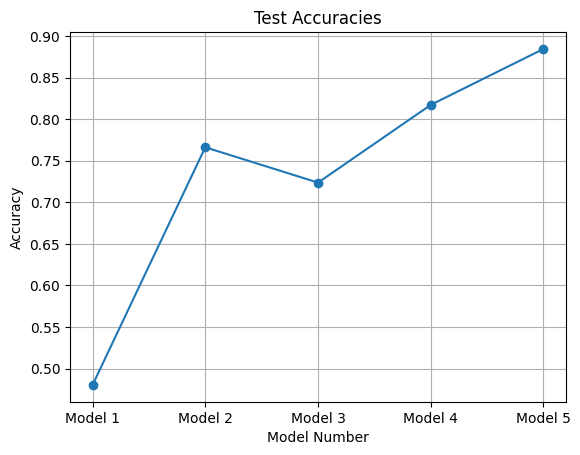

In [42]:
acc_list = [test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

# Plotting the accuracies
plt.plot(acc_list, marker='o', linestyle='-')
plt.title('Test Accuracies')
plt.xlabel('Model Number')
plt.ylabel('Accuracy')
plt.xticks(range(5), ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])  # Set x-axis labels
plt.grid(True)
plt.show()

As presented above, the highest accuracy has been maintained from Model 5, whose hyperparameters have been tuned by a grid search evaluation. As a result, it lead us to find the best hyperparameters, resulting the best accuracy.

### 4.2. Loss Comparison

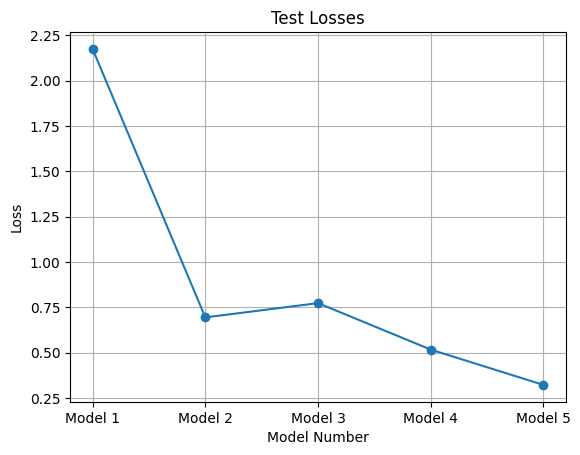

In [43]:
acc_list = [test_loss_1, test_loss_2, test_loss_3, test_loss_4, test_loss_5]

# Plotting the accuracies
plt.plot(acc_list, marker='o', linestyle='-')
plt.title('Test Losses')
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.xticks(range(5), ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])  # Set x-axis labels
plt.grid(True)
plt.show()

As we expected, the fifth model, which has the highest accuracy, has the lowest loss.

### 4.3. Accuracy and Loss of the 5th Model

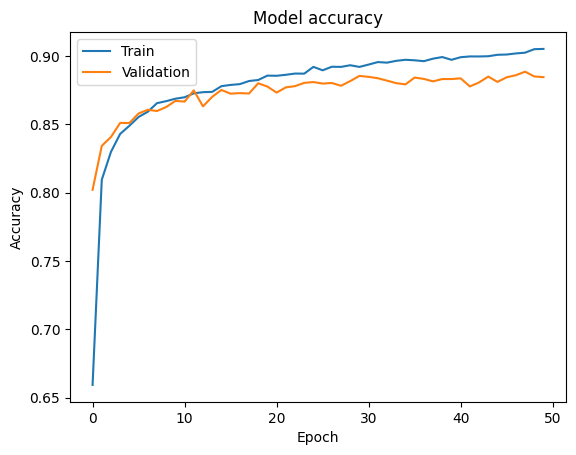

In [44]:
# Plot training & validation accuracy values
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

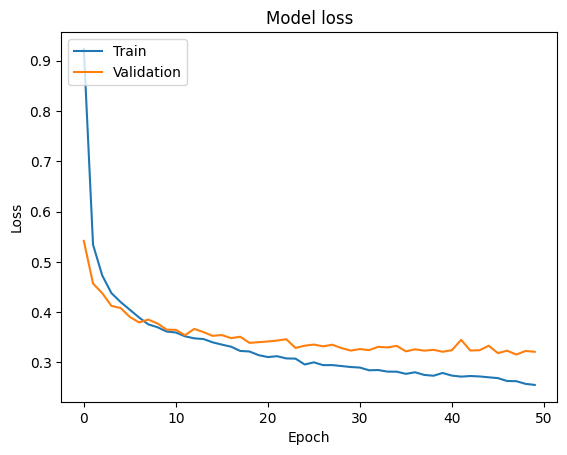

In [45]:
# Plot training & validation loss values
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We can visually confirm that there is no significant progress on accuracy and loss after 20th epoch.

### 4.4. Tests with the Fifth Model

In this section, we will be predicting 10 images from the test dataset.

1/1 [==============================] - 0s 150ms/step


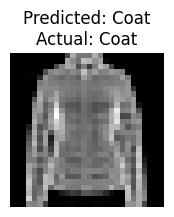

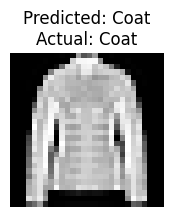

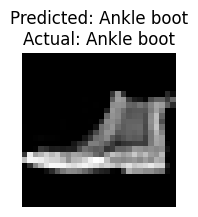

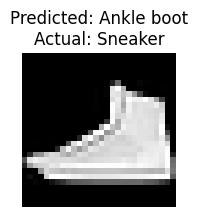

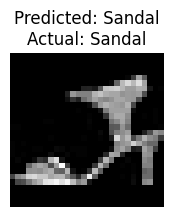

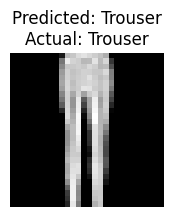

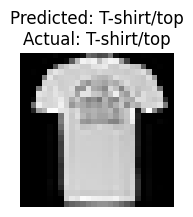

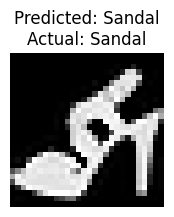

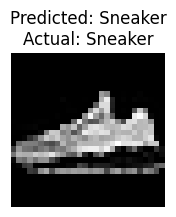

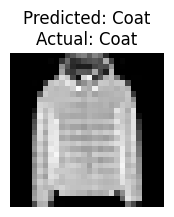

In [46]:
# Extract a batch of test images and labels from the test_dataset
test_images, test_labels = next(iter(test_dataset.batch(10)))

# Convert integer labels to one-hot encoded labels
test_labels_one_hot = to_categorical(test_labels, num_classes=len(class_names))

# Convert test_images to numpy arrays
test_images = test_images.numpy()

# Predicting categories of images by 5th model, which has the highest accuracy
predictions = model_5.predict(test_images)

# Obtain predicted class indices
predicted_indices = np.argmax(predictions, axis=1)

# Map class indices to class names
predicted_labels = [class_names[idx] for idx in predicted_indices]
actual_labels = [class_names[idx] for idx in np.argmax(test_labels_one_hot, axis=1)]

# Display images with predicted and actual labels
for i in range(len(test_images)):
    plt.figure(figsize=(2, 2))
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}\nActual: {actual_labels[i]}')
    plt.axis('off')
    plt.show()